In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc
import math
import random
import matplotlib
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.patches as patches
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 30)
from datetime import datetime
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
path='../input/ashrae-energy-prediction/'
path_new = '../input/lag-transform/'
path_new = '../input/transformer/'
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from math import log
import lightgbm as lgb
import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
pd.options.mode.chained_assignment = None
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import holidays
import os
from scipy.sparse import csr_matrix,coo_matrix, hstack
from sklearn.linear_model import Ridge
import seaborn as sns 
from sklearn.neighbors import KNeighborsRegressor
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))
def ls():
     print([v for v in globals().keys() if not v.startswith('_')])

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    
def free_space(del_list):
    for name in del_list:
        if not name.startswith('_'):
            del globals()[name]
    gc.collect()
    
def chunk_predictor(X,model,n=100,verbose=True):
    predict_fold = KFold(n)
    result = np.zeros(X.shape[0])
    if verbose:
        for trn_idx, val_idx in tqdm_notebook(predict_fold.split(X)):
               result[val_idx] = model.predict(X.iloc[val_idx,:])
    else:
        for trn_idx, val_idx in predict_fold.split(X):
            result[val_idx] = model.predict(X.iloc[val_idx,:])
    return(result)

# def one_hot_encoder(train,col,tr_index):
#     scaler = MinMaxScaler()
#     temp = csr_matrix(scaler.fit_transform(pd.get_dummies(train,prefix_sep='_',columns=col,drop_first=True)))
#     return(temp[:tr_index,:],temp[tr_index:,:])


def one_hot_encoder(train,col,tr_index):
    temp = (pd.get_dummies(train,prefix_sep='_',columns=col,drop_first=True)).values #csr_matrix
    return(temp[:tr_index,:],temp[tr_index:,:])


../input/ashrae-energy-prediction/sample_submission.csv
../input/ashrae-energy-prediction/building_metadata.csv
../input/ashrae-energy-prediction/weather_test.csv
../input/ashrae-energy-prediction/train.csv
../input/ashrae-energy-prediction/test.csv
../input/ashrae-energy-prediction/weather_train.csv


In [2]:
path_load = '../input/train-transformer/'
path_dataset ='../input/rescale-knn/'

train = pd.read_hdf(f'{path_dataset}dataset_rescale.h5',key='rescale_train')
test = pd.read_hdf(f'{path_dataset}dataset_rescale.h5',key='rescale_test')

# train = pd.read_hdf(f'{path_load}dataset.h5',key='train')
# test = pd.read_hdf(f'{path_load}dataset.h5',key='test')
# column = pd.read_hdf(f'{path_load}dataset.h5',key='column')['column'].tolist()
# timestamp = pd.read_hdf(f'{path_load}dataset.h5',key='timestamp')
# train['month']=timestamp.dt.month.astype(int)
# category_column = pd.read_hdf(f'{path_load}dataset.h5',key='category_column')['cat_column'].tolist()

target = pd.read_hdf(f'{path_load}dataset.h5',key='target')

support = pd.read_hdf(f'{path_load}dataset.h5',key='train')[['building_id','meter']]
valid_build = support['building_id'].copy()
valid_meter = support['meter'].copy()
del support
gc.collect()

99

In [3]:
SEED = 42
seed_everything(SEED)
gc.collect()

0

In [4]:
# valid_build = train['building_id'].copy()
# valid_meter = train['meter'].copy()
# gc.collect()

In [5]:
# replace = train.groupby('building_meter')['pm2k'].mean()

# train.loc[train.pm2k.isnull(),'pm2k'] = train['building_meter'].map(replace)[train.pm2k.isnull()]
# test.loc[test.pm2k.isnull(),'pm2k'] = test['building_meter'].map(replace)[test.pm2k.isnull()]

# strat_train = train['building_meter']
# strat_test = test['building_meter']

# train = train[['day','hour','weekend','air_temperature','dew_temperature',
#        'heat_index','feel','air_temperature_mean_lag24','dew_temperature_mean_lag24','feel_mean_lag24','heating_required','m2k','pm2k']]#'month',
# test = test[['day','hour','weekend','air_temperature','dew_temperature',
#        'heat_index','feel','air_temperature_mean_lag24','dew_temperature_mean_lag24','feel_mean_lag24','heating_required','m2k','pm2k']]#'month',


In [6]:
strat_train = train.pop('building_meter')
strat_test = test.pop('building_meter')


to_dummy = ['month','day','hour','weekend'] 

In [7]:
to_dummy = ['hour','weekend'] #'month','day',
train.drop(['month','day'],axis=1,inplace=True)
test.drop(['day','month'],axis=1,inplace=True)

In [8]:
n_fold = 2
# models = {}
cv_scores = {"build_meter": [], "cv_score": []}
seed = 0
kf = KFold(n_splits=n_fold, random_state=seed,shuffle=True)

pred_test = np.zeros(test.shape[0])
pred_x = np.zeros(train.shape[0])

In [9]:
%%time
num_nearest = 10

for sel in tqdm_notebook(np.sort(strat_train.unique())):
    temp = train[strat_train==sel]
    train_row = temp.shape[0]
    temp = temp.append(test[strat_test==sel],ignore_index =True)
    temp_train, temp_test = one_hot_encoder(temp,to_dummy,train_row)
    
    y = target.values[strat_train==sel]
    score = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(temp_train, y)):
        x_train, x_valid = temp_train[train_index,:], temp_train[valid_index,:]
        y_train, y_valid = y[train_index], y[valid_index]

        model = KNeighborsRegressor(n_neighbors = num_nearest,n_jobs = -1,algorithm ='kd_tree')
        model.fit(x_train, y_train)
        
        pred_test[strat_test==sel] += model.predict(temp_test)/n_fold
        pred_x[np.where(strat_train==sel)[0][valid_index]] += model.predict(x_valid)
        score += np.sqrt(mean_squared_error(y_valid, pred_x[np.where(strat_train==sel)[0][valid_index]]))/n_fold
    
#     print(f'cv score: {score}')
    cv_scores["build_meter"].append(sel)
    cv_scores["cv_score"].append(score)

    del temp, temp_train, y,x_train, x_valid, y_train, y_valid, model, score
    gc.collect()



CPU times: user 12h 29min 24s, sys: 3min 16s, total: 12h 32min 40s
Wall time: 3h 34min 39s


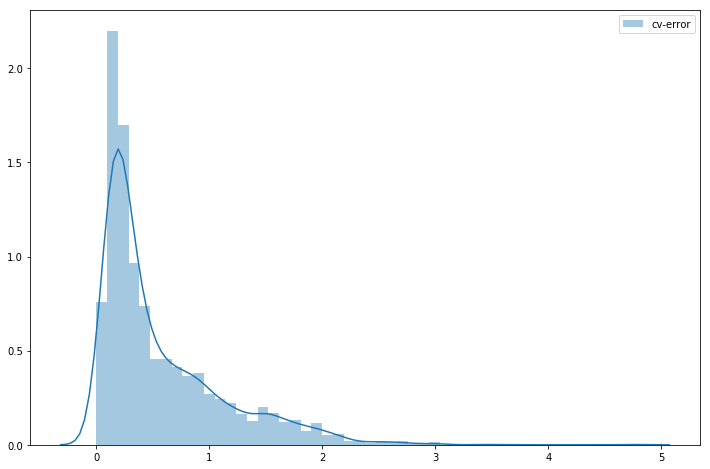

In [10]:
fig = plt.figure(figsize=(12,8))
sns.distplot(cv_scores['cv_score'],label ='cv-error')
plt.legend()


In [11]:
result = pd.DataFrame({'Building_ID':valid_build,'meter':valid_meter,'target_real':target,'target_pred':pred_x}).dropna()
result.reset_index(drop=True,inplace=True)
gc.collect()

free_space(['valid_build','valid_meter'])

gc.collect()

0

In [12]:
gc.collect()
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
sample_submission['meter_reading'] = np.expm1(pred_test)
# leak_df = pd.read_csv('../input/ashrae-leak-data-station/sample_leak.csv',index_col=0).dropna()
# sample_submission.loc[leak_df.index, 'meter_reading'] = leak_df['meter_reading']
# sample_submission.reset_index(inplace=True,drop=True)
sample_submission.loc[sample_submission['meter_reading']<0,'meter_reading'] = 0
sample_submission.to_csv('submission_linear.csv',index=False)


In [13]:
sample_submission.iloc[:50,:]

,row_id,meter_reading
0,0,214.024065
1,1,102.543618
2,2,8.610722
3,3,336.189904
4,4,1484.758091
...,...,...
45,45,128.539336
46,46,211.140852
47,47,497.519637
48,48,294.328184


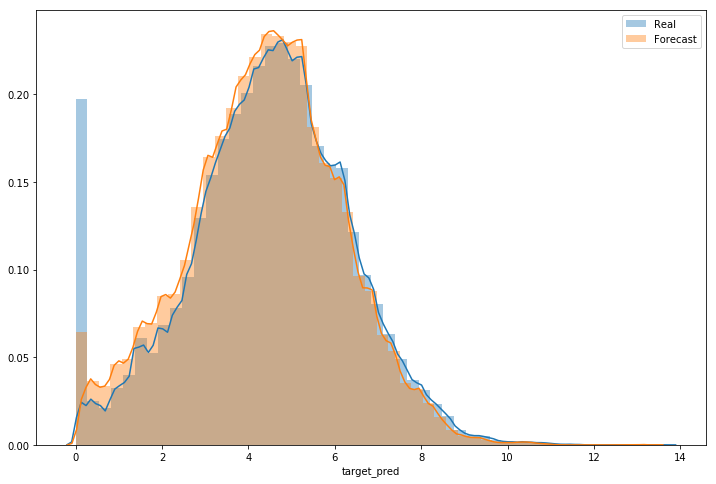

In [14]:
fig = plt.figure(figsize=(12,8))
sns.distplot(result.target_real,label='Real')
sns.distplot(result.target_pred,label='Forecast')
plt.legend()


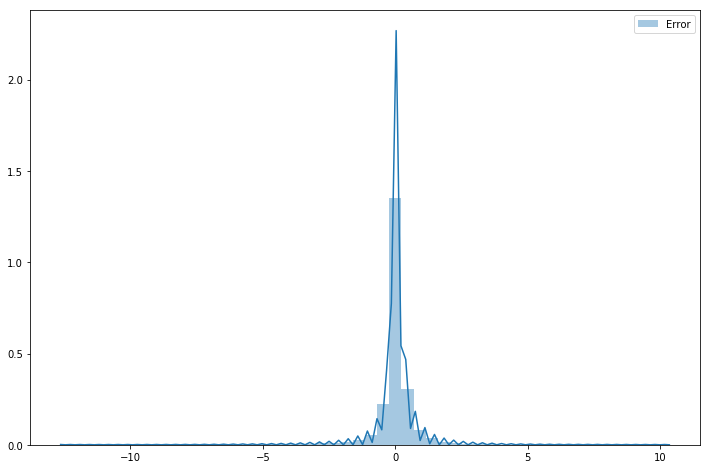

In [15]:
fig = plt.figure(figsize=(12,8))
sns.distplot((result.target_real-result.target_pred),label ='Error')
plt.legend()


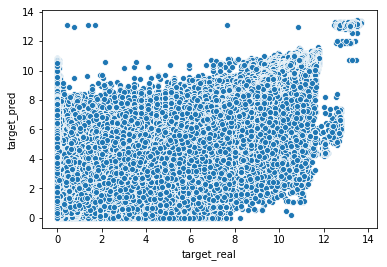

In [16]:
sns.scatterplot(x=result.target_real, y=result.target_pred)
